In [27]:
from pysqlite2 import dbapi2 as sql
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [28]:
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
con.enable_load_extension(True)
con.execute("SELECT load_extension('mod_spatialite');")

qry = '''
SELECT 
A.CL8AA1990 AS pop90,
A.CL8AA2000 AS pop00,
A.CL8AA2010 AS pop10,
B.*,
C.metro,
C.econdep
FROM
nhgis_pop_race_norm_90_10 AS A
JOIN county_segregation AS B
    ON A.GISJOIN = B.GISJOIN
JOIN usda_typology_2004 AS C 
    ON  A.STATEA || A.COUNTYA = C.FIPSTXT
;
'''

df = pd.read_sql(qry, con, index_col='GISJOIN')
con.close()
df.head()

,pop90,pop00,pop10,entropy_index_4grp_10,diversity_r_5grp_10,diversity_r_4grp_10,entropy_index_3grp_10,diversity_r_3grp_10,total_r_10,total_r_3grp_10,...,entropy_index_4grp_90,diversity_r_5grp_90,diversity_r_4grp_90,entropy_index_3grp_90,diversity_r_3grp_90,total_r_90,total_r_3grp_90,entropy_index_5grp_90,metro,econdep
GISJOIN,,,,,,,,,,,,,,,,,,,,,
G0100010,34223.68,43672.90,54571,0.110687,0.711386,0.693947,0.128904,0.583433,54571,53059,...,0.273178,0.574266,0.570610,0.287115,0.539365,34223.67,34034.63,0.273471,1,3
G0100030,98280.00,140415.00,182265,0.134068,0.625374,0.608817,0.165359,0.494894,182265,177158,...,0.285374,0.493293,0.488343,0.313353,0.441770,98280.00,97414.00,0.285886,0,5
G0100050,25417.62,29038.85,27457,0.135293,0.934404,0.925007,0.144139,0.859885,27457,27044,...,0.143364,0.735968,0.733707,0.145971,0.714086,25417.62,25334.62,0.144763,0,3
G0100070,16610.89,20826.41,22915,0.159603,0.679811,0.675678,0.175537,0.614933,22915,22621,...,0.107900,0.545190,0.543856,0.108717,0.529544,16610.89,16574.89,0.109452,1,6
G0100090,39251.65,51028.61,57322,0.109927,0.441631,0.434742,0.134996,0.351674,57322,56302,...,0.239949,0.143022,0.140900,0.285520,0.113755,39251.65,39083.51,0.243028,1,6


In [29]:
# how many counties?
len(df)

2403

In [30]:
# merge with census regions
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
con.enable_load_extension(True)
con.execute("SELECT load_extension('mod_spatialite');")

qry = '''
SELECT A.gisjoin, B.name AS region
FROM us_county_2010 AS A, census_regions_10 AS B
WHERE ST_Contains(B.geometry, ST_Centroid(A.geometry))
AND A.ROWID IN (SELECT ROWID FROM SpatialIndex
    WHERE f_table_name = 'us_county_2010' AND search_frame = B.geometry )
;
'''

df2 = pd.read_sql(qry, con, index_col='gisjoin')
con.close()
df2.head()

,region
gisjoin,
G3400170,Northeast
G3400110,Northeast
G2300190,Northeast
G5000090,Northeast
G5000110,Northeast


In [31]:
df = pd.merge(df, df2, left_index=True, right_index=True)

In [72]:
# create categories for pop change 2000 to 2010

# calc pop change
df['ppctchg_0010'] = ( df['pop10'] - df['pop00'] ) * 1.0 / df['pop00'] * 100
df['ppctchg_9000'] = ( df['pop00'] - df['pop90'] ) * 1.0 / df['pop90'] * 100
# growth categories 2000-2010
df['growth_cat'] = 0
df.loc[df['ppctchg_0010'] >= 5, 'growth_cat'] = 'growing'
df.loc[(df['ppctchg_0010'] < 5) & (df['ppctchg_0010'] >= 0 ), 'growth_cat'] = 'stable'
df.loc[df['ppctchg_0010'] < 0, 'growth_cat'] = 'shrinking'
# growth categories 1990-2000
df['growth_cat_90s'] = 0
df.loc[df['ppctchg_9000'] >= 5, 'growth_cat_90s'] = 'growing'
df.loc[(df['ppctchg_9000'] < 5) & (df['ppctchg_9000'] >= 0 ), 'growth_cat_90s'] = 'stable'
df.loc[df['ppctchg_9000'] < 0, 'growth_cat_90s'] = 'shrinking'

df.groupby('growth_cat').size()

growth_cat
growing      1134
shrinking     642
stable        622
dtype: int64

In [68]:
# xtab counties between 1990s and 2000s in terms of pop change category
pd.crosstab(df['growth_cat_90s'], df['growth_cat'], margins=True)

growth_cat,growing,shrinking,stable,All
growth_cat_90s,,,,
growing,1066,190,392,1648
shrinking,25,254,70,349
stable,43,198,160,401
All,1134,642,622,2398


Text(0.5,1,u'2000-2010')

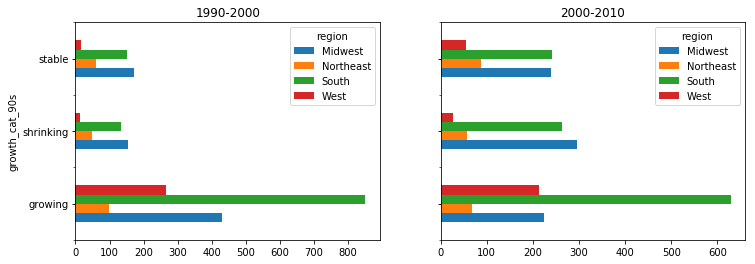

In [34]:
# how many loss counties by region?
w = 12
h = 4
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))

df.groupby(['growth_cat_90s', 'region']).size().unstack().plot(kind='barh', ax=ax1)
df.groupby(['growth_cat', 'region']).size().unstack().plot(kind='barh', ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

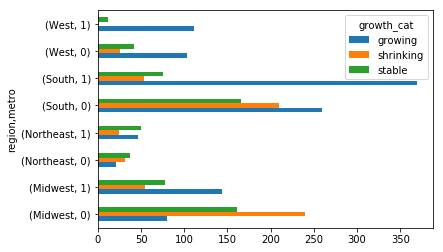

In [36]:
# group by metro status
# 1 = metro
df.groupby(['region', 'metro', 'growth_cat']).size().unstack().plot(kind='barh')

Text(0.5,1,u'2000-2010')

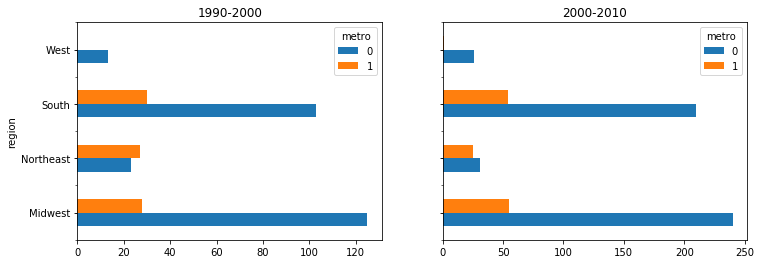

In [37]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))
df.loc[df['growth_cat_90s']=='shrinking'].groupby(['region', 'metro']).size().unstack().plot(kind='barh', ax=ax1)
df.loc[df['growth_cat']=='shrinking'].groupby(['region', 'metro']).size().unstack().plot(kind='barh', ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

In [40]:
# add labels for usda 2004 county typology codes
df['econdep_lbl'] = None
df.loc[df['econdep']==1, 'econdep_lbl'] = 'farming'
df.loc[df['econdep']==2, 'econdep_lbl'] = 'mining'
df.loc[df['econdep']==3, 'econdep_lbl'] = 'manufac'
df.loc[df['econdep']==4, 'econdep_lbl'] = 'govt'
df.loc[df['econdep']==5, 'econdep_lbl'] = 'services'
df.loc[df['econdep']==6, 'econdep_lbl'] = 'nonspec'

Text(0.5,1,u'2000-2010')

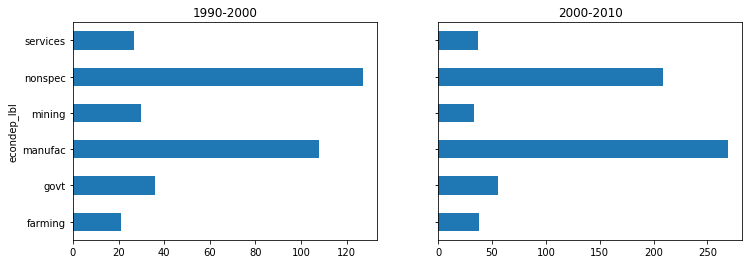

In [47]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))
df.loc[df['growth_cat_90s']=='shrinking'].groupby('econdep_lbl').size().plot(kind='barh', ax=ax1)
df.loc[df['growth_cat']=='shrinking'].groupby('econdep_lbl').size().plot(kind='barh', ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

Text(0.5,1,u'2000-2010')

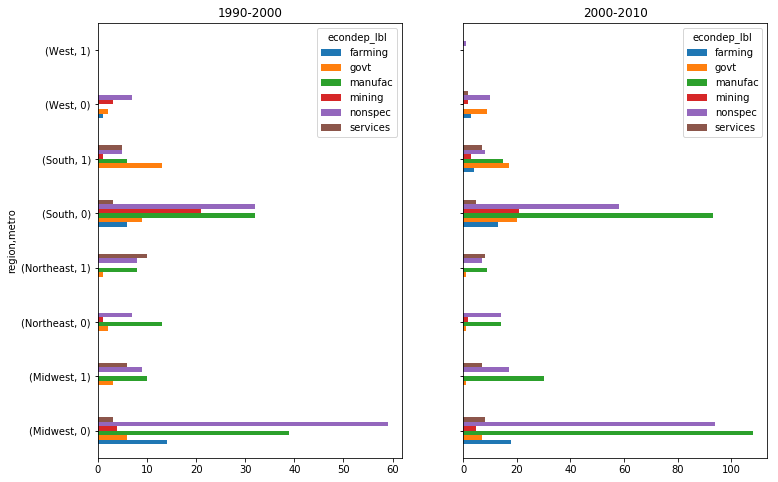

In [42]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12,8))
df.loc[df['growth_cat_90s']=='shrinking'].groupby(['region', 'metro', 'econdep_lbl']).size().unstack().plot(kind='barh', ax=ax1)
df.loc[df['growth_cat']=='shrinking'].groupby(['region', 'metro', 'econdep_lbl']).size().unstack().plot(kind='barh', ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

## diagnostics for diversity and segregation: four groups

* non-hispanic white
* non-hispanic black
* hispanic
* other

Text(0.5,1,u'2000-2010')

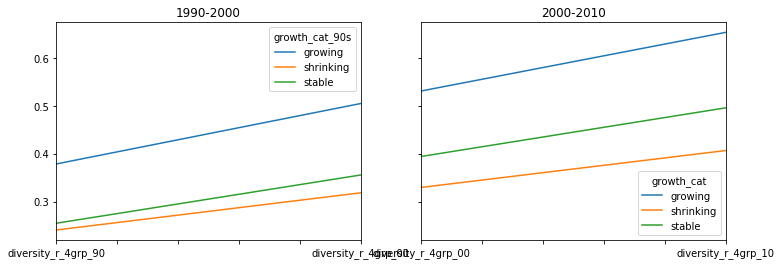

In [75]:
# plot change in median diversity across periods
# calculated using four groups

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))
cols1 = ['diversity_r_4grp_90', 'diversity_r_4grp_00']
cols2 = ['diversity_r_4grp_00', 'diversity_r_4grp_10']
df.groupby('growth_cat_90s')[cols1].median().transpose().plot(ax=ax1)
df.groupby('growth_cat')[cols2].median().transpose().plot(ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

Text(0.5,1,u'2000-2010')

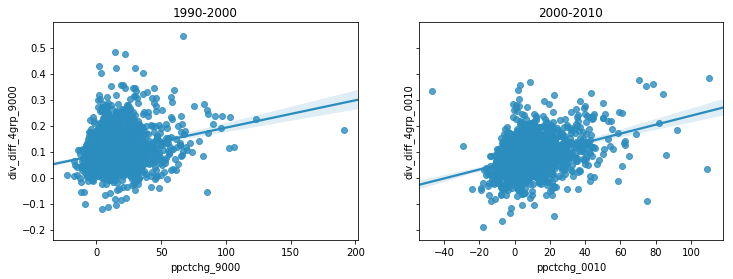

In [12]:
# plot difference in diversity score against percent pop change for both periods
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))

df['div_diff_4grp_9000'] = df['diversity_r_4grp_00'] - df['diversity_r_4grp_90']
df['div_diff_4grp_0010'] = df['diversity_r_4grp_10'] - df['diversity_r_4grp_00']

# df.plot.scatter('ppctchg_9000', 'div_diff_9000', ax=ax1)
# df.plot.scatter('ppctchg_0010', 'div_diff_0010', ax=ax2)
sns.regplot('ppctchg_9000', 'div_diff_4grp_9000', df, ax=ax1, color='#2b8cbe')
sns.regplot('ppctchg_0010', 'div_diff_4grp_0010', df, ax=ax2, color='#2b8cbe')
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

Text(0.5,1,u'2000-2010')

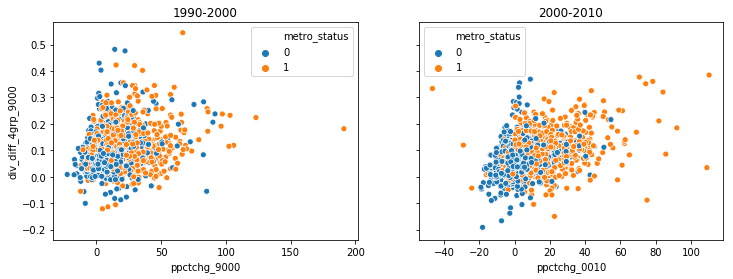

In [13]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))

sns.scatterplot(x='ppctchg_9000', y='div_diff_4grp_9000', data=df, ax=ax1, hue='metro_status')
sns.scatterplot(x='ppctchg_0010', y='div_diff_4grp_0010', data=df, ax=ax2, hue='metro_status')
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

Text(0.5,1,u'2000-2010')

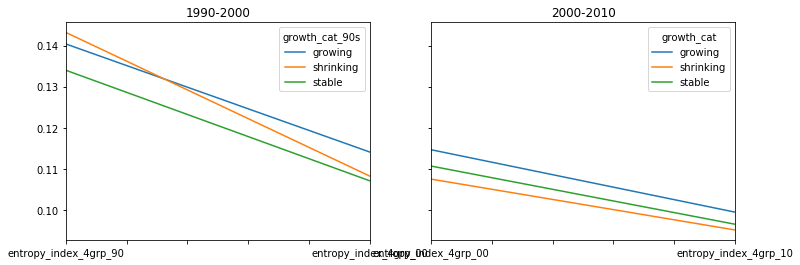

In [76]:
# plot change in median segregation across periods
# calculated using four groups
cols1 = ['entropy_index_4grp_90', 'entropy_index_4grp_00']
cols2 = ['entropy_index_4grp_00', 'entropy_index_4grp_10']
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))
df.groupby('growth_cat_90s')[cols1].median().transpose().plot(ax=ax1)
df.groupby('growth_cat')[cols2].median().transpose().plot(ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

Text(0.5,1,u'2000-2010')

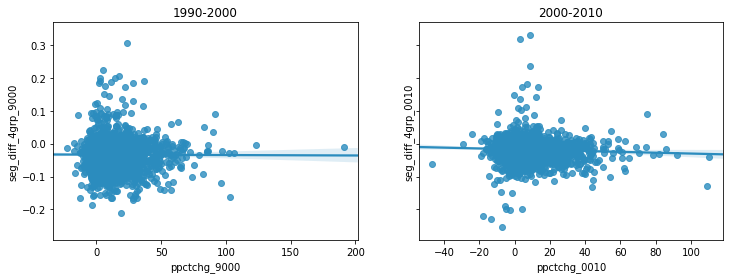

In [15]:
# plot difference in segregation score against percent pop change for both periods
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))

df['seg_diff_4grp_9000'] = df['entropy_index_4grp_00'] - df['entropy_index_4grp_90']
df['seg_diff_4grp_0010'] = df['entropy_index_4grp_10'] - df['entropy_index_4grp_00']

# df.plot.scatter('ppctchg_9000', 'seg_diff_4grp_9000', ax=ax1)
# df.plot.scatter('ppctchg_0010', 'seg_diff_4grp_0010', ax=ax2)
sns.regplot('ppctchg_9000', 'seg_diff_4grp_9000', df, ax=ax1, color='#2b8cbe')
sns.regplot('ppctchg_0010', 'seg_diff_4grp_0010', df, ax=ax2, color='#2b8cbe')
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

Text(0.5,1,u'2000-2010')

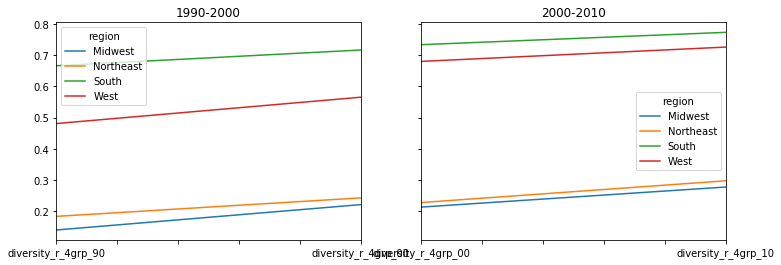

In [77]:
# show change in median diversity score by region for shrinking counties

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))

cols1 = ['diversity_r_4grp_90', 'diversity_r_4grp_00']
cols2 = ['diversity_r_4grp_00', 'diversity_r_4grp_10']

df.loc[df['growth_cat_90s']=='shrinking'].groupby('region')[cols1].median().transpose().plot(ax=ax1)
df.loc[df['growth_cat']=='shrinking'].groupby('region')[cols2].median().transpose().plot(ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

Text(0.5,1,u'2000-2010')

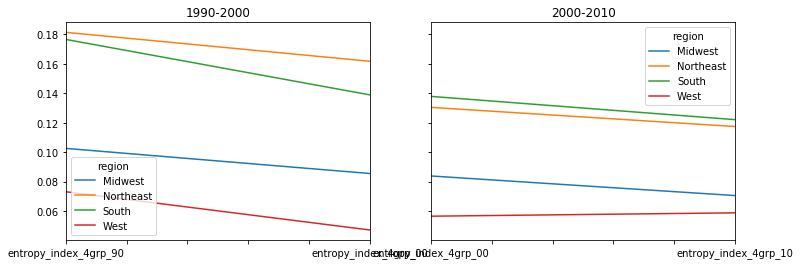

In [79]:
# show change by region for shrinking counties
# segregation

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))

cols1 = ['entropy_index_4grp_90', 'entropy_index_4grp_00']
cols2 = ['entropy_index_4grp_00', 'entropy_index_4grp_10']

df.loc[df['growth_cat_90s']=='shrinking'].groupby('region')[cols1].median().transpose().plot(ax=ax1)
df.loc[df['growth_cat']=='shrinking'].groupby('region')[cols2].median().transpose().plot(ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

Text(0.5,1,u'2000-2010')

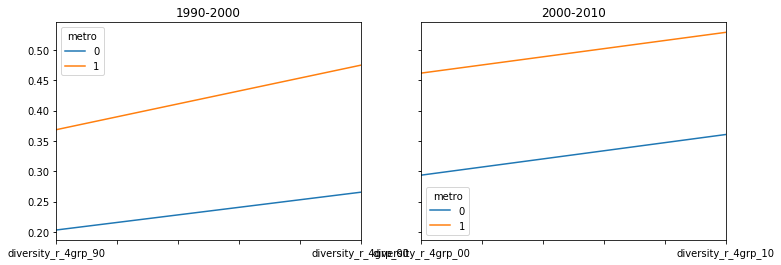

In [86]:
# show change by metro status for shrinking counties

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))

cols1 = ['diversity_r_4grp_90', 'diversity_r_4grp_00']
cols2 = ['diversity_r_4grp_00', 'diversity_r_4grp_10']

df.loc[df['growth_cat_90s']=='shrinking'].groupby('metro')[cols1].median().transpose().plot(ax=ax1)
df.loc[df['growth_cat']=='shrinking'].groupby('metro')[cols2].median().transpose().plot(ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

(0.0, 1.0, 0.091713482093782273, 0.81369319808191887)

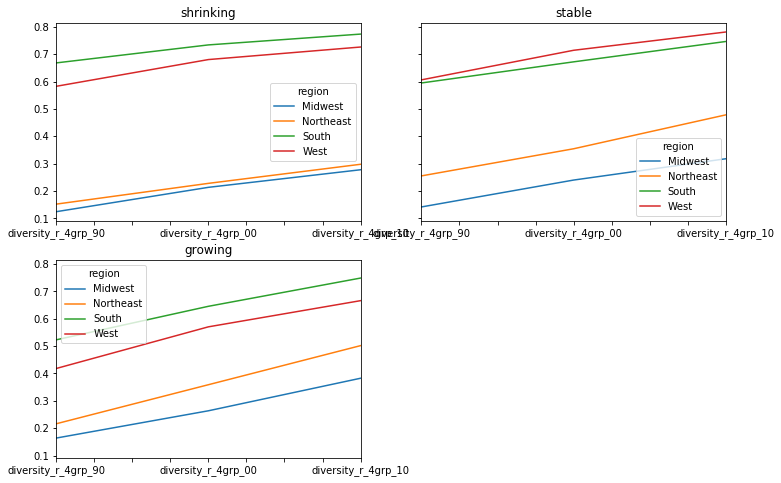

In [88]:
# show change by region for shrinking counties
# segregation

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(12,8))

cols = ['diversity_r_4grp_90', 'diversity_r_4grp_00', 'diversity_r_4grp_10']

df.loc[df['growth_cat']=='shrinking'].groupby('region')[cols].median().transpose().plot(ax=ax1)
df.loc[df['growth_cat']=='stable'].groupby('region')[cols].median().transpose().plot(ax=ax2)
df.loc[df['growth_cat']=='growing'].groupby('region')[cols].median().transpose().plot(ax=ax3)
ax1.set_title('shrinking')
ax2.set_title('stable')
ax3.set_title('growing')
ax4.axis('off')

(0.0, 1.0, 0.080917168978526466, 0.83773604609428121)

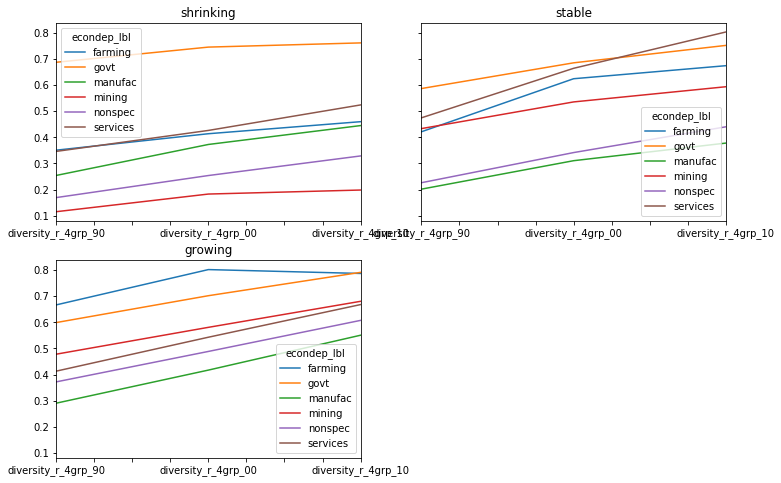

In [84]:
# show change by region for shrinking counties
# segregation

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(12,8))

cols = ['diversity_r_4grp_90', 'diversity_r_4grp_00', 'diversity_r_4grp_10']

df.loc[df['growth_cat']=='shrinking'].groupby('econdep_lbl')[cols].median().transpose().plot(ax=ax1)
df.loc[df['growth_cat']=='stable'].groupby('econdep_lbl')[cols].median().transpose().plot(ax=ax2)
df.loc[df['growth_cat']=='growing'].groupby('econdep_lbl')[cols].median().transpose().plot(ax=ax3)
ax1.set_title('shrinking')
ax2.set_title('stable')
ax3.set_title('growing')
ax4.axis('off')

Text(0.5,1,u'2000-2010')

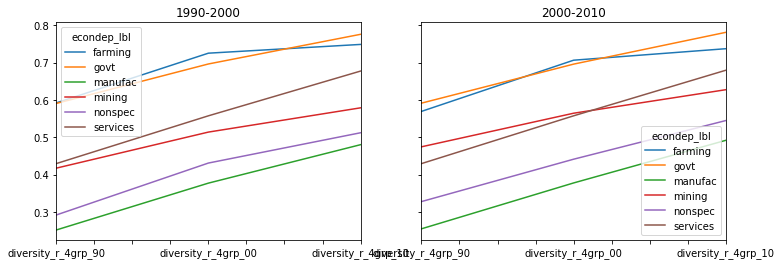

In [52]:
# show change by region for growing and stable counties
# segregation

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))

cols = ['diversity_r_4grp_90', 'diversity_r_4grp_00', 'diversity_r_4grp_10']

df.loc[df['growth_cat_90s']!='shrinking'].groupby('econdep_lbl')[cols].median().transpose().plot(ax=ax1)
df.loc[df['growth_cat']!='shrinking'].groupby('econdep_lbl')[cols].median().transpose().plot(ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

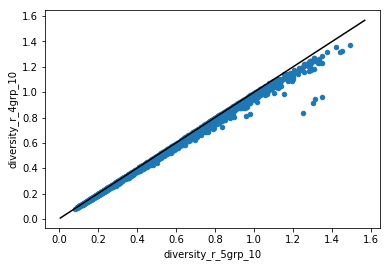

In [20]:
# plot five group diversity against four group diversity
ax=df.plot.scatter('diversity_r_5grp_10', 'diversity_r_4grp_10')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color='black')

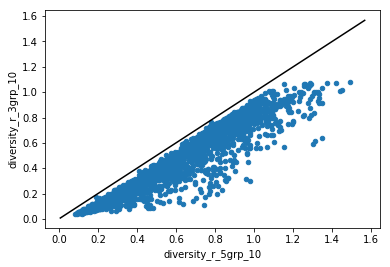

In [21]:
# plot five group diversity against four group diversity
ax=df.plot.scatter('diversity_r_5grp_10', 'diversity_r_3grp_10')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color='black')